<a href="https://www.kaggle.com/code/fbasampaio/data-imbalance-solutions?scriptVersionId=220848293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

**Import data**

In [2]:
df_id = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")
df_trans = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
df_trans.head(4)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train=df_trans.merge(df_id,how='left',left_index=True,right_index=True)

del df_trans,df_id

train.head(2)

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


**Handle Missing Values**

In [4]:
# Replace null values with the mode in all columns
train = train.apply(lambda col: col.fillna(col.mode()[0] if not col.mode().empty else col), axis=0)
train.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,321.0,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


**Encoded strings**

In [5]:
from sklearn.preprocessing import LabelEncoder

# Instanciar o LabelEncoder
label_encoder = LabelEncoder()

# Aplicar Label Encoding em todas as colunas categóricas
for col in train.columns:
    if train[col].dtype == 'object':  # Verifica se a coluna é do tipo 'object'
        train[col] = label_encoder.fit_transform(train[col])

# Exibir o DataFrame resultante
train.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,321.0,150.0,1,142.0,...,123,32.0,164,3,1,0,1,1,1,954
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,98,32.0,48,2,1,0,0,1,1,1727
2,2987002,0,86469,59.0,4,4663,490.0,150.0,3,166.0,...,44,24.0,132,3,0,0,1,1,0,1598
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,44,24.0,132,3,0,0,1,1,0,1598
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,44,24.0,40,3,1,0,1,1,0,723


**Resumetable**

In [6]:
from scipy import stats

def resumetable(train):
    print(f"Dataset Shape: {train.shape}")
    summary = pd.DataFrame(train.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = train.isnull().sum().values    
    summary['Uniques'] = train.nunique().values
    summary['First Value'] = train.loc[0].values
    summary['Second Value'] = train.loc[1].values
    summary['Third Value'] = train.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(train[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = train.memory_usage().sum() / 1024**2    
    for col in train.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)    
    end_mem = train.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(train): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(train), np.std(train)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in train if x < lower]
    outliers_higher = [x for x in train if x > upper]
    outliers_total = [x for x in train if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in train if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [7]:
resumetable(train)[:25]

Dataset Shape: (590540, 435)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID_x,int64,0,590540,2987000.0,2987001.0,2987002.0,19.17
1,isFraud,int64,0,2,0.0,0.0,0.0,0.22
2,TransactionDT,int64,0,573349,86400.0,86401.0,86469.0,19.11
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.35
4,ProductCD,int64,0,5,4.0,4.0,4.0,1.28
5,card1,int64,0,13553,13926.0,2755.0,4663.0,9.97
6,card2,float64,0,500,321.0,404.0,490.0,6.28
7,card3,float64,0,114,150.0,150.0,150.0,0.68
8,card4,int64,0,4,1.0,2.0,3.0,1.09
9,card5,float64,0,119,142.0,102.0,166.0,2.65


In [8]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(train):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train.columns:
        col_type = train[col].dtype
        
        if col_type != object:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)
        else:
            train[col] = train[col].astype('category')

    end_mem = train.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [9]:
%%time
train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 527.70 MB
Decreased by 73.1%
CPU times: user 2.8 s, sys: 937 µs, total: 2.8 s
Wall time: 2.8 s


In [10]:
# Separate the features (X) and the target variable (y)
X = train.drop('isFraud', axis=1)  # Remove the 'isFraud' column from X
y = train['isFraud']  # y contains only the 'isFraud' column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Oversampling

In [11]:
from sklearn.utils import resample

# Assuming X_train and y_train are already defined and are DataFrames/Series
train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
not_fraud = train[train.isFraud == 0]
fraud = train[train.isFraud == 1]

# Check the number of samples in the minority class
original_no_fraud_count = len(not_fraud)
original_fraud_count = len(fraud)

print(f'Original number of non-fraud cases: {original_no_fraud_count}')
print(f'Original number of fraud cases: {original_fraud_count}')

# Upsample the minority class (fraud) to match the number of samples in the majority class
train = resample(fraud,
                          replace=True,
                          n_samples=len(not_fraud),
                          random_state=42)  # Reproducible results

# Combine the majority and minority classes
train = pd.concat([not_fraud, train])

# Count the distribution of classes in the upsampled dataset
print('Class distribution after oversampling:')
print(train.isFraud.value_counts())


Original number of non-fraud cases: 455903
Original number of fraud cases: 16529
Class distribution after oversampling:
isFraud
0    455903
1    455903
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

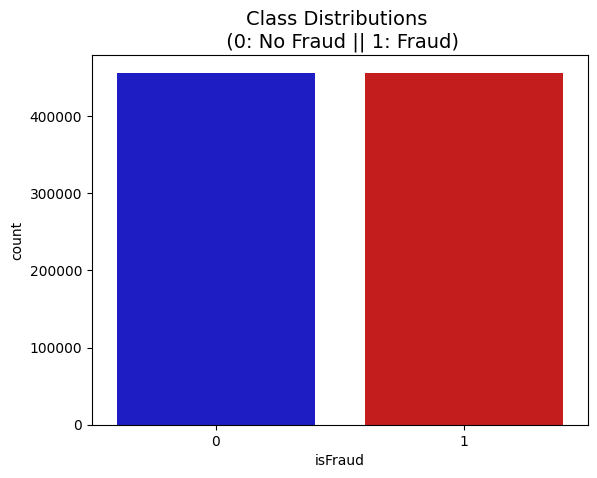

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='isFraud', data=train , palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

SMOTE

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(Counter(y_train_smote))



Class distribution after SMOTE:
Counter({0: 455903, 1: 455903})


ADASYN

In [14]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=1)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print("\nClass distribution after ADASYN:")
print(Counter(y_train_adasyn))



Class distribution after ADASYN:
Counter({1: 459547, 0: 455903})


Borderline_smote

In [15]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

borderline_smote = BorderlineSMOTE(random_state=1)

X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train, y_train)

print("\nClass distribution after Borderline-SMOTE:")
print(Counter(y_train_borderline_smote))



Class distribution after Borderline-SMOTE:
Counter({0: 455903, 1: 455903})


Random_under_sampler

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

random_under_sampler = RandomUnderSampler(random_state=1)

X_train_under, y_train_under = random_under_sampler.fit_resample(X_train, y_train)

print("\nClass distribution after Undersampling:")
print(Counter(y_train_under))



Class distribution after Undersampling:
Counter({0: 16529, 1: 16529})


In [17]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

# Inicializar TomekLinks
tomek_links = TomekLinks()

# Aplicar TomekLinks para obter o novo conjunto de dados balanceado
X_train_under, y_train_under = tomek_links.fit_resample(X_train, y_train)

print("\nClass distribution after Tomek Links:")
print(Counter(y_train_under))



Class distribution after Tomek Links:
Counter({0: 451331, 1: 16529})
